Predicting Pass Result on Short vs Long Passes From Defensive Formation

Research Question 1:

How well can a defensive formation predict the outcome of a pass? 
Does short vs deep pass plays affect our ability to predict the outcome?

In [50]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

In [25]:
plays = pd.read_csv("/content/plays.csv")

plays.head(10)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False
5,2018090600,320,(10:10) (Shotgun) N.Foles pass short left to N...,1,2,8,PHI,play_type_pass,PHI,4,...,0.0,10:10:00,14.0,NaN,NaN,C,4,4,-0.344096,False
6,2018090600,344,(9:24) (Shotgun) N.Foles pass incomplete short...,1,3,4,PHI,play_type_pass,PHI,8,...,0.0,09:24:00,18.0,NaN,NaN,I,0,0,-1.192208,False
7,2018090600,402,(9:08) M.Ryan pass incomplete deep left to M.S...,1,1,10,ATL,play_type_pass,PHI,44,...,0.0,09:08:00,54.0,NaN,NaN,I,0,0,-0.429863,False
8,2018090600,492,(7:01) M.Ryan pass short left to T.Coleman pus...,1,2,13,ATL,play_type_pass,PHI,36,...,0.0,07:01:00,46.0,NaN,NaN,C,26,26,1.879804,False
9,2018090600,521,(6:19) M.Ryan pass short left to A.Hooper to P...,1,1,10,ATL,play_type_pass,PHI,10,...,0.0,06:19:00,20.0,NaN,NaN,C,3,3,0.045665,False


In [26]:
# Here we do some preprocessing:
#  - Taking out plays that end in interceptions, penalties, and fumbles
#  - Then taking only the passing plays since we are not focusing on runs
#  - We can see that we are using a total of 16,197 passing plays


df = plays.copy()
words = "INTERCEPTED|PENALTY|FUMBLES"
passes = df[df['playDescription'].str.contains(" pass ", case=False, na=False)]
filtered = passes[~passes['playDescription'].str.contains(words, case=False, na=False)]
filtered.shape[0]

16197

In [27]:
# Here we created data tables from the play table based on the location and result (complete or incomplete) of a pass

# The "playDescription" column was a text string describing the events of the play. From this we extracted what happened
# during the play and filtered the rows into their respective table

incomplete_short = filtered[filtered['playDescription'].str.contains("incomplete short", case=False, na=False)]
incomplete_deep = filtered[filtered['playDescription'].str.contains("incomplete deep", case=False, na=False)]
complete_short = filtered[filtered['playDescription'].str.contains("pass short", case=False, na=False)]
complete_deep = filtered[filtered['playDescription'].str.contains("pass deep", case=False, na=False)]

#complete_short.to_csv("/Users/williamzwetolitz/Desktop/DS320/Data/complete_short.csv")
#complete_deep.to_csv("/Users/williamzwetolitz/Desktop/DS320/Data/complete_deep.csv")
#incomplete_short.to_csv("/Users/williamzwetolitz/Desktop/DS320/Data/incomplete_short.csv")
#incomplete_deep.to_csv("/Users/williamzwetolitz/Desktop/DS320/Data/incomplete_deep.csv")

In [ ]:
# Similar to above, but this time splitting pass plays, regardless of outcome, into short and long passes

short = filtered[filtered['playDescription'].str.contains("short", case=False, na=False)]
deep = filtered[filtered['playDescription'].str.contains("deep", case=False, na=False)]

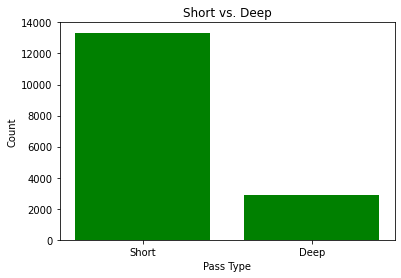

In [30]:
pass_type = ['Short', 'Deep']
counts = [short.shape[0], deep.shape[0]]
plt.bar(pass_type, counts, color = 'green')
 
# Add title and axis names
plt.title('Short vs. Deep')
plt.xlabel('Pass Type')
plt.ylabel('Count')

plt.show()

In [31]:
# Removed plays where the number of defenders in the box was unknown

short = short[pd.notnull(short['defendersInTheBox'])]
short['defendersInTheBox'].isna().sum()

0

In [32]:
# The variables used to predict are:
# yardsToGo - Distance needed for the offense to gain a first down
#       May affect how aggressive a QB is, how they throw it, and type of pass they throw
# defendersInTheBox - Number of defenders in close proximity to line-of-scrimmage
#       Relates to how many players drop into coverage to protect the pass, the less players, the harder it is to pass
# numberOfPassRushers - Number of players rushing the quarterback
#       This affects how much time the QB as to throw

# The prediction variable is passResult, either complete or incomplete

# The data was split into training and testing, with 30% reserved for the latter

X = short[['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers']]
y = short['passResult']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
# Here we train a random forest classifier using 100 estimators. RFC is a good choice here as it performs well in 
# classification problems like this one, effective at avoiding overfitting and can provide relative feature importance

short_clf=RandomForestClassifier(n_estimators=100)

short_clf.fit(X_train,y_train)
y_pred=short_clf.predict(X_test)

In [34]:
# Here we see the accuracy of our model

print("Model accuracy on short passes:",metrics.accuracy_score(y_test, y_pred))

rfc_short_acc = metrics.accuracy_score(y_test, y_pred)

print(rfc_short_acc)

Model accuracy on short passes: 0.7005253940455342
0.7005253940455342


In [35]:
# Now, we will repeat the same process for deep passes

deep = deep[pd.notnull(deep['defendersInTheBox'])]

X = deep[['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers']]
y = deep['passResult']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [36]:
clf2=RandomForestClassifier(n_estimators=100)

clf2.fit(X_train,y_train)
y_pred=clf2.predict(X_test)

In [37]:
print("Model accuracy on deep passes:",metrics.accuracy_score(y_test, y_pred))

rfc_deep_acc = metrics.accuracy_score(y_test, y_pred)

print(rfc_deep_acc)

Model accuracy on deep passes: 0.5442890442890443
0.5442890442890443


We can see that the prediction accuracy was much higher for short passes than long passes. This is expected because deep passes are much less consistant than short passes in the NFL. 

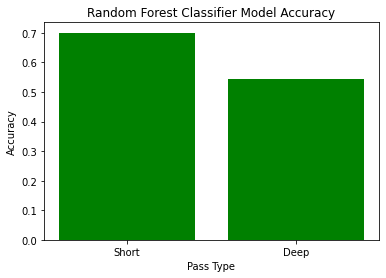

In [40]:
pass_type = ['Short', 'Deep']
accuracy = [rfc_short_acc, rfc_deep_acc]
plt.bar(pass_type, accuracy, color = 'green')
 
# Add title and axis names
plt.title('Random Forest Classifier Model Accuracy')
plt.xlabel('Pass Type')
plt.ylabel('Accuracy')

plt.show()

In [41]:
# Created a binary representation of the resutl of pass play. O for incomplete and 1 for complete.

short['binaryPassResult'] = [0 if x == 'I' else 1 for x in short["passResult"]]
deep['binaryPassResult'] = [0 if x == 'I' else 1 for x in deep["passResult"]]
short.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI,binaryPassResult
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False,1
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False,0
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False,0
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False,0
5,2018090600,320,(10:10) (Shotgun) N.Foles pass short left to N...,1,2,8,PHI,play_type_pass,PHI,4,...,10:10:00,14.0,NaN,NaN,C,4,4,-0.344096,False,1


In [42]:
# Using XGB for the same question looking at short passes
from xgboost import XGBClassifier

params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }

X = short[['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers']]
y = short['binaryPassResult']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)



In [43]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier()

In [44]:
y_pred = model.predict(X_test)
preds = [round(value) for value in y_pred]

accuracy_short = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy_short * 100.0))


Accuracy: 71.33%


In [45]:
# Now doing XGBoost on deep passes

from xgboost import XGBClassifier

params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }

X = deep[['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers']]
y = deep['binaryPassResult']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)


In [46]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier()

In [47]:
y_pred = model.predict(X_test)
preds = [round(value) for value in y_pred]

accuracy_deep = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy_deep * 100.0))

Accuracy: 56.99%


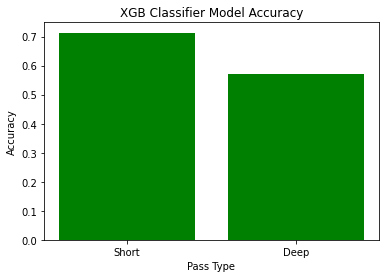

In [48]:
pass_type = ['Short', 'Deep']
accuracy = [accuracy_short, accuracy_deep]
plt.bar(pass_type, accuracy, color = 'green')
 
# Add title and axis names
plt.title('XGB Classifier Model Accuracy')
plt.xlabel('Pass Type')
plt.ylabel('Accuracy')

plt.show()

In [49]:
accuracy_data = [["Random Forest Classifier", rfc_short_acc, rfc_deep_acc], ["XGBoost", accuracy_short, accuracy_deep]]

col_names = ["Model", "Short Passes", "Long Passes"]

print(tabulate(accuracy_data, headers=col_names))

Model                       Short Passes    Long Passes
------------------------  --------------  -------------
Random Forest Classifier        0.700525       0.544289
XGBoost                         0.713321       0.56993


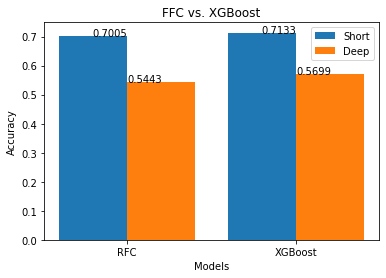

In [69]:
def addlabels(x,y, alignment):
    for i in range(len(x)):
        plt.text(i, y[i].round(4), y[i].round(4), ha = alignment)

X = ['RFC','XGBoost']
short = [rfc_short_acc, accuracy_short]
deep = [rfc_deep_acc, accuracy_deep] 
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, short, 0.4, label = 'Short')
plt.bar(X_axis + 0.2, deep, 0.4, label = 'Deep')
addlabels(X_axis, short, 'right')
addlabels(X_axis, deep, 'left')
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("FFC vs. XGBoost")
plt.legend()
plt.show()